In [5]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [38]:
from edmAnalyzer import sequenceCalculator
from edmAnalyzer import parityStateTransform, combine_switches

import math
import pickle
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mpld3
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
plt.ioff()

class sequenceVisualizer:

    @staticmethod
    def _load_results(result_file_path):
        """Load the pickled results from the file."""
        try:
            with open(result_file_path, 'rb') as f:
                sequenceresult = pickle.load(f)
            return sequenceresult
        except Exception as e:
            print(f"Error loading results: {e}")
            return None
        
    def __init__(self, sequenceresult_file_path, figure_folder_path, sequence_json_path):
        self.sequenceresult = self._load_results(sequenceresult_file_path)
        self.sequenceparameter = sequenceCalculator.Parameters()
        self.sequenceparameter._load_parameters_from_json(sequence_json_path)
        self.sequencename = self.sequenceresult.sequence_name
        self.sequencestring = self.sequenceresult.sequence_string
        self.blind_id = self.sequenceresult.blinded.blind_id
        self.superblock_switches = self.sequenceresult.superblock_parity_switches
        self.non_parity_switches = self.sequenceresult.non_parity_switches
        self.block_switches = ['N', 'E', 'B']
        _, self.superblock_parity_labels, self.superblock_state_labels = parityStateTransform(channelName= self.superblock_switches)
        _, self.block_parity_labels, self.block_state_labels = parityStateTransform(channelName= self.block_switches)
        self.labels = combine_switches(self.superblock_parity_labels, self.block_parity_labels)[1]
        self.figure_folder_path = figure_folder_path
        self.sipm_color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

    def _propagate_error_bar(A, dA2, axis_to_take_average, nan = False):
        if nan:
            if isinstance(axis_to_take_average, int):
                axis_to_take_average = (axis_to_take_average,)

            selected_dimension = [A.shape[i] for i in axis_to_take_average]

            if np.prod(selected_dimension) == 1:
                A_mean = A
                dA_mean_square_scaled = dA2
                red_chi_square = np.full(A.shape, np.nan)
                dA_mean_square_unscaled = dA2
                return A_mean, dA_mean_square_unscaled, dA_mean_square_scaled, red_chi_square

            weights = 1 / dA2
            A_mean = np.nansum(A * weights, axis=axis_to_take_average, keepdims=True) / np.nansum(weights, axis=axis_to_take_average, keepdims=True)

            dA_mean_square_unscaled = 1 / np.nansum(weights, axis=axis_to_take_average, keepdims=True)

            total_number_of_points = np.nanprod([A.shape[axis] for axis in axis_to_take_average])
            residuals = (A - A_mean)**2
            red_chi_square = np.nansum(residuals / dA2, axis=axis_to_take_average, keepdims=True) / (total_number_of_points - 1)

            dA_mean_square_scaled = dA_mean_square_unscaled * red_chi_square

            return A_mean, dA_mean_square_unscaled, dA_mean_square_scaled, red_chi_square
        
        else:

            if isinstance(axis_to_take_average, int):
                axis_to_take_average = (axis_to_take_average,)

            selected_dimension = [A.shape[i] for i in axis_to_take_average]

            if np.prod(selected_dimension) == 1:
                A_mean = A
                dA_mean_square_scaled = dA2
                red_chi_square = np.full(A.shape, np.nan)
                dA_mean_square_unscaled = dA2
                return A_mean, dA_mean_square_unscaled, dA_mean_square_scaled, red_chi_square

            weights = 1 / dA2
            A_mean = np.sum(A * weights, axis=axis_to_take_average, keepdims=True) / np.sum(weights, axis=axis_to_take_average, keepdims=True)

            dA_mean_square_unscaled = 1 / np.sum(weights, axis=axis_to_take_average, keepdims=True)

            total_number_of_points = np.prod([A.shape[axis] for axis in axis_to_take_average])
            residuals = (A - A_mean)**2
            red_chi_square = np.sum(residuals / dA2, axis=axis_to_take_average, keepdims=True) / (total_number_of_points - 1)

            dA_mean_square_scaled = dA_mean_square_unscaled * red_chi_square

            return A_mean, dA_mean_square_unscaled, dA_mean_square_scaled, red_chi_square

    def _visualize_final_results_1d(self, quantity, dquantity2, sipm_red_chi_square_quantity, unit="", folder = None):
        """
        Visualize the final results for the given quantity in 1D plots, one for each element in self.labels.
        
        Parameters:
        - quantity: the key for the quantity in self.sequenceresult.blinded.final_result
        - dquantity2: the key for the error associated with quantity
        - sipm_red_chi_square_quantity: the key for the reduced chi-square quantity
        - unit: the unit string to attach to the displayed value (default: "")
        """
        for i in range(len(self.labels)):

            j_dim = list(self.sequenceresult.blinded.final_result[quantity].values())[0].shape[2]
            for j in range(j_dim):
                x_values = []
                y_values = []
                yerr_values = []
                non_parity_keys = []
                for non_parity_key in self.sequenceresult.blinded.final_result[quantity].keys():
                    label = self.labels[i][j] if j < len(self.labels[i]) else f'Unknown_Label_{i}_{j}'
                    
                    # Extract x, y, and yerr values
                    x_values.append(non_parity_key[0] if len(non_parity_key) > 0 else 0)
                    y_values.append(self.sequenceresult.blinded.final_result[quantity][non_parity_key][i, 0, j, 0, 0, 0, 0])
                    yerr_values.append(np.sqrt(self.sequenceresult.blinded.final_result[dquantity2][non_parity_key][i, 0, j, 0, 0, 0, 0]))
                    non_parity_keys.append(non_parity_key)
                # Create a new figure for each plot
                fig, ax = plt.subplots(figsize=(12,8))

                # Plot the point with error bars in black
                ax.errorbar(x_values, y_values, yerr=yerr_values, fmt='o', 
                            color='black', capsize=5)

                # Set axis labels
                ax.set_xlabel(f"{','.join(self.non_parity_switches)}")
                ax.set_ylabel(f'{quantity} {unit}')
                
                # Add grid
                ax.grid(True)

                # Set the plot title with multiple lines
                title = f"{self.labels[i][j]}\n" \
                        f"{','.join(self.non_parity_switches)}\n" \
                        f"{self.sequencename + self.sequencestring}\n" \
                        f"{self.blind_id}"
                ax.set_title(title, fontsize=12)
                # Get current y-limits to place the text correctly
                ylim = ax.get_ylim()
                for x_value,y_value,y_err,non_parity_key in zip(x_values, y_values, yerr_values, non_parity_keys):
                # Format the y_value for scientific notation
                    y_value_sci = "{:.3e}".format(y_value)
                    y_err_sci = "{:.3e}".format(y_err)
                    # Add text displaying the value in scientific notation
                    ax.text(x_value, y_value - 0.15 * (ylim[1] - ylim[0]), f"{y_value_sci} {unit}", 
                            ha='center', va='top', fontsize=10)

                    ax.text(x_value, y_value - 0.25 * (ylim[1] - ylim[0]), f"$\pm${y_err_sci} {unit}", 
                            ha='center', va='top', fontsize=10)

                    # Display the reduced chi-square value below the y_value
                    red_chi_square_value = self.sequenceresult.blinded.final_result[sipm_red_chi_square_quantity][non_parity_key][i, 0, j, 0, 0, 0, 0]
                    ax.text(x_value, y_value - 0.05 * (ylim[1] - ylim[0]), 
                            rf"$\chi^2_{{red}}(SiPM) = {red_chi_square_value:.2f}$", 
                            ha='center', va='top', fontsize=10)

                # Apply a tight layout to ensure the elements fit well
                fig.tight_layout()

                if quantity == "omega":
                    if np.max(np.abs(y_values)) > 0.1:
                        fig.patch.set_facecolor('yellow')

                # Save the individual plot with the appropriate filename
                if label == "nr":
                    fig_filename = f"{folder}/nonreversing_{quantity}.png"
                else:
                    fig_filename = f"{folder}/{label}_{quantity}.png"
                plt.savefig(fig_filename)
                plt.close(fig)

    def visualize_final_results_1d(self, interested_in = ['omega', 'tau', 'phi', 'C']):
        folder_path = os.path.join(self.figure_folder_path, 'result_vs_nonparity')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)


        for subfolder_name in interested_in:
            subfolder_path = os.path.join(folder_path, subfolder_name)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

        if 'omega' in interested_in:
            self._visualize_final_results_1d('omega', 'domega2', 'sipm_red_chi_square_omega', 'rad/s', folder=os.path.join(folder_path, 'omega'))
        if 'tau' in interested_in:
            self._visualize_final_results_1d('tau', 'dtau2', 'sipm_red_chi_square_tau', 's', folder=os.path.join(folder_path, 'tau'))
        if 'phi' in interested_in:
            self._visualize_final_results_1d('phi', 'dphi2', 'sipm_red_chi_square_phi', 'rad', folder=os.path.join(folder_path, 'phi'))
        if 'C' in interested_in or 'A' in interested_in:
            self._visualize_final_results_1d('C', 'dC2', 'sipm_red_chi_square_C', '', folder=os.path.join(folder_path, 'C'))
        if 'A' in interested_in:
            self._visualize_final_results_1d('A', 'dA2', 'sipm_red_chi_square_A', '', folder=os.path.join(folder_path, 'A'))
        if 'Ap' in interested_in or 'Am' in interested_in:
            self._visualize_final_results_1d('Ap', 'dAp2', 'sipm_red_chi_square_Ap', '', folder=os.path.join(folder_path, 'Ap'))
        if 'Am' in interested_in:
            self._visualize_final_results_1d('Am', 'dAm2', 'sipm_red_chi_square_Am', '', folder=os.path.join(folder_path, 'Am'))

    def visualize_degenerate_blocks(self, blockheader_df, additional_columns):
        def plot_block_quantities(df, blockheader_df, save_path, superblock_parity_switches, non_parity_switches, additional_columns):
            # Merge df with blockheader_df on 'run', 'sequence', and 'block'
            df = pd.merge(df, blockheader_df, on=['run', 'sequence', 'block'], how='left', suffixes= (None, '_duplicate'))
            
            # Define quantities and channels
            quantities = ["C", "phi", "omega", "tau", "A", "Ap", "Am"]
            channels = ["nr", "N", "E", "B", "NE", "NB", "EB", "NEB"]
            sipm_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

            # Function to create tick labels with formatted mean and chi-square
            def create_tick_label(row, switches, mean_value=None, red_chi2=None):
                labels = []
                for switch in switches:
                    sign = "+" if row[switch] > 0 else ""
                    labels.append(f"{switch}\n{sign}{row[switch]}")
                if mean_value is not None and red_chi2 is not None:
                    labels.append(f"mean\n{mean_value:.2g}\n$\chi^2_{{red}}[blocks]$ \n{red_chi2:.2g}")
                return "\n".join(labels)

            for quantity in quantities:
                quantity_path = os.path.join(save_path, f"block_{quantity}")
                os.makedirs(quantity_path, exist_ok=True)
                channels_to_plot = channels if quantity != "tau" else ["nr"]

                for channel in channels_to_plot:
                    fig, ax = plt.subplots(figsize=(24, 12))
                    x = range(len(df))

                    # Plot SiPM values with reduced alpha
                    for i in range(8):
                        if f'block_{quantity}_{channel}_sipm{i}' in df.columns:
                            sipm_y = df[f'block_{quantity}_{channel}_sipm{i}']
                            ax.scatter(x, sipm_y, color=sipm_colors[i], label=f'SiPM {i}', alpha=0.4, marker='.', s=100)

                    # Plot center values with error bars
# Plot center values with error bars and annotate block numbers
# Plot center values with error bars and annotate block numbers
                    y = df[f'block_{quantity}_{channel}']
                    y_err = df[f'blockuncertainty_{quantity}_{channel}']
                    ax.errorbar(x, y, yerr=y_err, fmt='.', capsize=4, capthick=4, ecolor='black', color='black', markersize=6)

                    # Annotate block numbers in bright green (#00FF00) with bold text and larger font size
                    for i, (xi, yi, bi) in enumerate(zip(x, y, df['block'])):
                        if not pd.isnull(yi):  # Only annotate valid points
                            ax.text(
                                xi, yi + y_err.iloc[i] + 0.05 * max(y_err),  # Adjust position to appear just above the error bar
                                f"{int(bi)}",  # Convert block number to integer for display
                                color='#FF0000',  # Bright green color
                                fontsize=10,  # Slightly larger font size
                                fontweight='bold',  # Make text bold
                                ha='center',  # Center-align the text horizontally
                                va='bottom'  # Align text to the bottom to ensure it appears above the error bar
                            )


                    # Prepare to collect all legends
                    lines_labels = [ax.get_legend_handles_labels()]
                    
                    # Plot additional columns with separate y-axes for each one
                    for i, col in enumerate(additional_columns):
                        ax2 = ax.twinx()
                        ax2.spines["right"].set_position(("outward", 60 * i))  # Separate y-axes for each column
                        line = ax2.plot(x, df[col], label=col, linestyle='-', color=f'C{i}')
                        ax2.set_ylabel(col)
                        ax2.tick_params(axis='y')
                        ax2.yaxis.label.set_color(f'C{i}')
                        
                        # Collect handles and labels for the current axis
                        lines_labels.append(ax2.get_legend_handles_labels())

                    # Combine all the legends into one on the main axis
                    handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
                    ax.legend(handles, labels, loc='upper right')

                    # Variables for interval processing
                    ticks, tick_labels = [], []
                    prev_non_parity, prev_superblock = None, None
                    superblock_start = 0
                    interval_y, interval_y_err = [], []

                    # Loop through data
                    for index, row in df.iterrows():
                        non_parity_values = tuple(row[switch] for switch in non_parity_switches)
                        superblock_values = tuple(row[switch] for switch in superblock_parity_switches)

                        # Handle non-parity changes
                        if prev_non_parity is None or non_parity_values != prev_non_parity:
                            if prev_non_parity is not None:
                                ax.axvline(x=index - 0.5, linestyle='--', color='black', linewidth=1)
                            prev_non_parity = non_parity_values

                        # Handle superblock changes
                        if prev_superblock is None or superblock_values != prev_superblock:
                            if prev_superblock is not None:
                                ax.axvline(x=index - 0.5, linestyle='--', color='black', linewidth=1)


                                """
                                # Calculate weighted mean and chi-square
                                if interval_y:
                                    weights = 1 / np.square(interval_y_err)
                                    weighted_avg = np.sum(interval_y * weights) / np.sum(weights)
                                    chi_square = np.sum(weights * (interval_y - weighted_avg)**2) / (len(interval_y) - 1)
                                    ax.hlines(weighted_avg, superblock_start - 0.5, index - 0.5, colors='red', linestyles='dashed')

                                    # Label for previous interval
                                    mid_point = (superblock_start + index) // 2
                                    tick_label = create_tick_label(df.iloc[superblock_start], superblock_parity_switches+non_parity_switches, weighted_avg, chi_square)
                                    ticks.append(mid_point)
                                    tick_labels.append(tick_label)
                                """

# Calculate robust mean and chi-square
                                if interval_y:
                                    # Convert interval values to numpy arrays
                                    interval_y = np.array(interval_y)
                                    interval_y_err = np.array(interval_y_err)
                                    
                                    # Calculate initial mean and standard deviation
                                    initial_mean = np.mean(interval_y)
                                    std_dev = np.std(interval_y)

                                    # Apply sigma clipping: keep only values within 3 sigma of the mean
                                    mask = np.abs(interval_y - initial_mean) <= 3 * std_dev
                                    clipped_y = interval_y[mask]
                                    clipped_y_err = interval_y_err[mask]

                                    # Check if enough points remain after clipping
                                    if len(clipped_y) > 1:
                                        weights = 1 / np.square(clipped_y_err)
                                        robust_mean = np.sum(clipped_y * weights) / np.sum(weights)
                                        chi_square = np.sum(weights * (clipped_y - robust_mean) ** 2) / (len(clipped_y) - 1)
                                    else:
                                        # Fallback to mean without clipping if not enough points
                                        robust_mean = np.mean(interval_y)
                                        chi_square = np.nan  # Cannot calculate chi-square with fewer points

                                    ax.hlines(robust_mean, superblock_start - 0.5, index - 0.5, colors='red', linestyles='dashed')

                                    # Label for previous interval
                                    mid_point = (superblock_start + index) // 2
                                    tick_label = create_tick_label(df.iloc[superblock_start], superblock_parity_switches + non_parity_switches, robust_mean, chi_square)
                                    ticks.append(mid_point)
                                    tick_labels.append(tick_label)


                            # Reset for next interval
                            superblock_start = index
                            interval_y, interval_y_err = [], []
                            prev_superblock = superblock_values

                        # Collect values for the current interval
                        interval_y.append(row[f'block_{quantity}_{channel}'])
                        interval_y_err.append(row[f'blockuncertainty_{quantity}_{channel}'])

                    # Last interval
                    if interval_y:
                        weights = 1 / np.square(interval_y_err)
                        weighted_avg = np.sum(interval_y * weights) / np.sum(weights)
                        chi_square = np.sum(weights * (interval_y - weighted_avg)**2) / (len(interval_y) - 1)
                        ax.hlines(weighted_avg, superblock_start - 0.5, len(df) - 0.5, colors='red', linestyles='dashed')
                        mid_point = (superblock_start + len(df)) // 2
                        tick_label = create_tick_label(df.iloc[superblock_start], superblock_parity_switches + non_parity_switches , weighted_avg, chi_square)
                        ticks.append(mid_point)
                        tick_labels.append(tick_label)

                    # Apply labels and save
                    ax.set_xticks(ticks)
                    ax.set_xticklabels(tick_labels)
                    ax.tick_params(axis='x', labelsize=7)
                    ax.tick_params(axis='y', labelsize=15)
                    ax.set_title(f"{quantity} - {channel}", fontsize=40)
                    ax.grid(axis='y')
                    plt.tight_layout()
                    fig.savefig(os.path.join(quantity_path, f"{quantity}_{channel}.png"))
                    plt.close(fig)


        def plot_block_N(df, blockheader_df, save_path, superblock_parity_switches, non_parity_switches, additional_columns):
            # Merge df with blockheader_df on 'run', 'sequence', and 'block'
            df = pd.merge(df, blockheader_df, on=['run', 'sequence', 'block'], how='left', suffixes= (None, '_duplicate'))

            # Define channels and colors
            channels = ["nr", "N", "E", "B", "NE", "NB", "EB", "NEB"]
            sipm_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

            # Path setup for 'N' quantities
            quantity_path = os.path.join(save_path, "block_N")
            os.makedirs(quantity_path, exist_ok=True)

            # Function to create tick labels without mean or chi-square
            def create_tick_label(row, switches):
                return "\n".join([f"{switch}\n{'+' if row[switch] > 0 else ''}{row[switch]}" for switch in switches])

            for channel in channels:
                fig, ax = plt.subplots(figsize=(24, 12))
                x = range(len(df))

                # Scatter plot for SiPM values with reduced alpha
                for i in range(8):
                    if f'block_N_{channel}_sipm{i}' in df.columns:
                        sipm_y = df[f'block_N_{channel}_sipm{i}']
                        ax.scatter(x, sipm_y, color=sipm_colors[i], label=f'SiPM {i}', alpha=0.4, marker='.', s=100)

                # Plot center values as black dots (sum over 8 SiPMs)
                y = df[f'block_N_{channel}'] / 8
                ax.plot(x, y, 'k.', markersize=6)

                # Prepare to collect all legends
                lines_labels = [ax.get_legend_handles_labels()]

                # Plot additional columns with separate y-axes for each one
                for i, col in enumerate(additional_columns):
                    ax2 = ax.twinx()
                    ax2.spines["right"].set_position(("outward", 60 * i))  # Separate y-axes for each column
                    line = ax2.plot(x, df[col], label=col, linestyle='-', color=f'C{i}')
                    ax2.set_ylabel(col)
                    ax2.tick_params(axis='y')
                    ax2.yaxis.label.set_color(f'C{i}')
                    
                    # Collect handles and labels for the current axis
                    lines_labels.append(ax2.get_legend_handles_labels())

                # Combine all the legends into one on the main axis
                handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
                ax.legend(handles, labels, loc='upper right')

                # Variables for interval processing
                ticks, tick_labels = [], []
                prev_non_parity, prev_superblock = None, None
                superblock_start = 0

                # Loop through data
                for index, row in df.iterrows():
                    non_parity_values = tuple(row[switch] for switch in non_parity_switches)
                    superblock_values = tuple(row[switch] for switch in superblock_parity_switches)

                    # Handle non-parity changes
                    if prev_non_parity is None or non_parity_values != prev_non_parity:
                        if prev_non_parity is not None:
                            ax.axvline(x=index - 0.5, linestyle='--', color='black', linewidth=4)
                        prev_non_parity = non_parity_values

                    # Handle superblock changes
                    if prev_superblock is None or superblock_values != prev_superblock:
                        if prev_superblock is not None:
                            ax.axvline(x=index - 0.5, linestyle='--', color='black', linewidth=4)

                            # Label for previous interval
                            mid_point = (superblock_start + index) // 2
                            tick_label = create_tick_label(df.iloc[superblock_start], superblock_parity_switches+non_parity_switches)
                            ticks.append(mid_point)
                            tick_labels.append(tick_label)

                        superblock_start = index
                        prev_superblock = superblock_values

                # Apply labels and save
                ax.set_xticks(ticks)
                ax.set_xticklabels(tick_labels)
                ax.tick_params(axis='x', labelsize=7)
                ax.tick_params(axis='y', labelsize=15)
                ax.set_title(f"N - {channel} /8", fontsize=40)
                ax.grid(axis='y')
                plt.tight_layout()
                fig.savefig(os.path.join(quantity_path, f"N_{channel}.png"))
                plt.close(fig)

        folder_path = os.path.join(self.figure_folder_path, 'blockview_timeorder')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        df = self.sequenceresult.blockdf
        save_path = folder_path
        superblock_parity_switches = self.superblock_switches
        non_parity_switches = self.non_parity_switches

        plot_block_quantities(df, blockheader_df, save_path, superblock_parity_switches, non_parity_switches, additional_columns)
        plot_block_N(df, blockheader_df,save_path, superblock_parity_switches, non_parity_switches, additional_columns)

        sort_columns = non_parity_switches + superblock_parity_switches + ['run', 'sequence', 'block']
        df_sorted = df.sort_values(by=sort_columns)
        df_sorted.reset_index(inplace=True)
        folder_path = os.path.join(self.figure_folder_path, 'blockview_stateorder')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        save_path = folder_path
        plot_block_quantities(df_sorted, blockheader_df,save_path, superblock_parity_switches, non_parity_switches, additional_columns)
        plot_block_N(df_sorted, blockheader_df, save_path, superblock_parity_switches, non_parity_switches, additional_columns)

    def _visualize_groups(dic, error2_dic, labels, name, non_parity_switches, figure_path, k_begin, k_end, unit):
        # Ensure the figure path exists
        os.makedirs(figure_path, exist_ok=True)

        # Extract the shape i and j from the first item in dic
        sample_matrix = next(iter(dic.values()))
        i, j = sample_matrix.shape[0], sample_matrix.shape[2]

        # Sort dictionary keys for consistent ordering in plots
        sorted_keys = sorted(dic.keys())

        # Initialize color map for gradual coloring
        cmap = plt.cm.viridis
        colors = [cmap(x / len(sorted_keys)) for x in range(len(sorted_keys))]

        for idx_i in range(i):
            for idx_j in range(j):
                # Create figure with specified size
                fig, ax = plt.subplots(figsize=(20, 12))  # 2x size increase for each dimension

                x_data = np.arange(k_begin, k_end)

                for line_idx, key in enumerate(sorted_keys):
                    # Extract the data for the specific slice and key
                    y_data = dic[key][idx_i, 0, idx_j, 0, 0, 0, k_begin:k_end]

                    # Calculate ±1 sigma range if error2_dic is provided
                    if error2_dic:
                        y_errors = np.sqrt(error2_dic[key][idx_i, 0, idx_j, 0, 0, 0, k_begin:k_end])
                        ax.fill_between(x_data, y_data - y_errors, y_data + y_errors,
                                        color=colors[line_idx], alpha=0.1)

                    # Plot the data points
                    line_label = ', '.join([f"{np_switch} = {state}" for np_switch, state in zip(non_parity_switches, key)])
                    ax.plot(x_data, y_data, label=line_label, color=colors[line_idx],
                            marker='.',  markersize=15, alpha=0.5)

                # Set plot labels and add grid
                ax.set_xlabel('Groups')
                ax.set_ylabel(unit)
                ax.grid(True)

                # Set title with increased font size
                ax.set_title(f"{name}_{labels[idx_i][idx_j]}", fontsize=32)

                # Add a thick black dashed line at y=0
                ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

                # Set axis limits and increase y-axis tick density
                ax.set_xlim(k_begin, k_end)
                ax.yaxis.set_major_locator(plt.MaxNLocator(20))

                # Add legend to the top right corner
                ax.legend(loc='upper right')

                # Save the figure
                if labels[idx_i][idx_j] == "nr":
                    fig_name = f"{name}_nonreversing.png"
                else:
                    fig_name = f"group_{name}_{labels[idx_i][idx_j]}.png"
                fig_path = os.path.join(figure_path, fig_name)
                plt.savefig(fig_path)
                plt.close(fig)

    def visualize_groups(self):
        folder_path = os.path.join(self.figure_folder_path, 'result_vs_groups')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        for subfolder_name in ('omega', 'tau', 'phi', 'C', 'A'):
            subfolder_path = os.path.join(folder_path, subfolder_name)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
        omega = {}
        domega2 = {}
        tau = {}
        dtau2 = {}
        phi = {}
        dphi2 = {}
        C = {}
        dC2 = {}
        A = {}
        dA2 = {}
        for key in self.sequenceresult.blinded.result['omega'].keys():
            omega[key], domega2[key], _,_ = sequenceVisualizer._propagate_error_bar(self.sequenceresult.blinded.result['omega'][key], self.sequenceresult.blinded.result['domega2'][key], -2)
            tau[key], dtau2[key], _,_ = sequenceVisualizer._propagate_error_bar(self.sequenceresult.blinded.result['tau'][key], self.sequenceresult.blinded.result['dtau2'][key], -2)
            phi[key], dphi2[key], _,_ = sequenceVisualizer._propagate_error_bar(self.sequenceresult.blinded.result['phi'][key], self.sequenceresult.blinded.result['dphi2'][key], -2)
            C[key], dC2[key], _,_ = sequenceVisualizer._propagate_error_bar(self.sequenceresult.blinded.result['C'][key], self.sequenceresult.blinded.result['dC2'][key], -2)
            A[key], dA2[key], _,_ = sequenceVisualizer._propagate_error_bar(self.sequenceresult.blinded.result['A'][key], self.sequenceresult.blinded.result['dA2'][key], -2)
        sequenceVisualizer._visualize_groups(omega, domega2, self.sequenceresult.labels, 'omega', self.non_parity_switches, os.path.join(folder_path, 'omega'), self.sequenceresult.sequence_group_left, self.sequenceresult.sequence_group_right, 'rad/s')
        sequenceVisualizer._visualize_groups(tau, dtau2, self.sequenceresult.labels, 'tau', self.non_parity_switches, os.path.join(folder_path, 'tau'), self.sequenceresult.sequence_group_left, self.sequenceresult.sequence_group_right, 's')
        sequenceVisualizer._visualize_groups(phi, dphi2, self.sequenceresult.labels, 'phi', self.non_parity_switches, os.path.join(folder_path, 'phi'), self.sequenceresult.sequence_group_left, self.sequenceresult.sequence_group_right, 'rad')
        sequenceVisualizer._visualize_groups(C, dC2, self.sequenceresult.labels, 'C', self.non_parity_switches, os.path.join(folder_path, 'C'), self.sequenceresult.sequence_group_left, self.sequenceresult.sequence_group_right, '')
        sequenceVisualizer._visualize_groups(A, dA2, self.sequenceresult.labels, 'A', self.non_parity_switches, os.path.join(folder_path, 'A'), self.sequenceresult.sequence_group_left, self.sequenceresult.sequence_group_right, '')



    def _safe_t_pvalue(tstat: float, dof: int) -> float:
        """Two-sided p-value for a t-statistic; SciPy if available, else normal approx."""
        try:
            from scipy.stats import t as tdist  # type: ignore
            return 2.0 * tdist.sf(abs(tstat), df=dof)
        except Exception:
            z = abs(tstat)
            phi = 0.5 * (1.0 + math.erf(z / np.sqrt(2.0)))
            return max(0.0, min(1.0, 2.0 * (1.0 - phi)))

    def _linear_fit_with_cov(x, y, sigma=None):
        """
        Fit y = β0 + β1 x.
        If sigma provided: WLS with weights 1/sigma^2, else OLS.
        Returns dict with β0, β1, their SEs, t-stats, dof, chi2_red (WLS), yfit,
        and R^2 (weighted if WLS), plus sigma_hat for OLS.
        """
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        n = x.size
        X = np.column_stack((np.ones_like(x), x))
        dof = max(n - 2, 1)

        if sigma is not None:
            w = 1.0 / np.asarray(sigma, dtype=float)**2
            W = np.diag(w)
            XtWX = X.T @ W @ X
            XtWy = X.T @ W @ y
            beta = np.linalg.solve(XtWX, XtWy)  # [β0, β1]
            yfit = X @ beta
            # chi2 and covariance (scaled by reduced chi^2)
            chi2 = float(np.sum(w * (y - yfit)**2))
            chi2_red = chi2 / dof
            cov = np.linalg.inv(XtWX) * chi2_red
            # Weighted R^2
            ybar_w = np.sum(w * y) / np.sum(w)
            ss_res_w = np.sum(w * (y - yfit)**2)
            ss_tot_w = np.sum(w * (y - ybar_w)**2)
            r2 = float(1.0 - ss_res_w / ss_tot_w) if ss_tot_w > 0 else np.nan
            sigma_hat = None
        else:
            XtX = X.T @ X
            XtY = X.T @ y
            beta = np.linalg.solve(XtX, XtY)
            yfit = X @ beta
            resid = y - yfit
            s2 = float((resid @ resid) / dof)        # variance estimator
            cov = np.linalg.inv(XtX) * s2
            chi2_red = None
            # Classic R^2
            ybar = float(np.mean(y))
            ss_res = float(np.sum((y - yfit)**2))
            ss_tot = float(np.sum((y - ybar)**2))
            r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
            sigma_hat = float(np.sqrt(s2))

        se = np.sqrt(np.diag(cov))
        tstats = beta / se
        return {
            "beta0": float(beta[0]),
            "beta1": float(beta[1]),
            "se0": float(se[0]),
            "se1": float(se[1]),
            "t0": float(tstats[0]),
            "t1": float(tstats[1]),
            "cov": cov,
            "yfit": yfit,
            "dof": dof,
            "chi2_red": chi2_red,
            "r2": r2,
            "sigma_hat": sigma_hat,  # only non-None for OLS
        }

    def _plot_sipm_errorbar(
        channel: str,
        sipm_df: pd.DataFrame,
        quantity_of_interest: str,
        plot_against: str,
        title: str = "",
        *,
        linear_fit: bool = False,
    ):
        """
        Top subplot: error bars (avg ± unc) and SiPM scatters (0..7).
        Bottom subplot: neatly formatted fit results (WLS & OLS) with β0/β1, SEs, t-stats,
        p-value for β1, R^2, and σ̂ for OLS.

        Now hardened with try/except so regression and line plotting never raise.
        """
        sipm_colors_list = [
            "blue","orange","green","red","purple","brown","pink","gray"
        ]

        base = f"{quantity_of_interest}_{channel}_"
        sipm_cols = [base + f"sipm{i}" for i in range(8)]
        sipm_avg_col = base + "sipmavg"
        unc_cols = [f"uncertainty_{c}" for c in sipm_cols]
        unc_avg_col = f"uncertainty_{sipm_avg_col}"

        needed_cols = [plot_against, sipm_avg_col, unc_avg_col] + sipm_cols + unc_cols
        missing = [c for c in needed_cols if c not in sipm_df.columns]
        if missing:
            raise KeyError(f"Missing required columns: {missing}")

        # Stable 2-row layout
        fig, (ax, ax_text) = plt.subplots(
            nrows=2, ncols=1, figsize=(8, 8),
            gridspec_kw={"height_ratios": [3, 1]}
        )

        # --- Top: data ---
        for _, row in sipm_df.iterrows():
            try:
                x = row[plot_against]
                y_avg = row[sipm_avg_col]
                yerr_avg = row[unc_avg_col]

                ax.errorbar(
                    x, y_avg, yerr=yerr_avg, fmt="o",
                    ecolor="black", capsize=4, capthick=1.2, elinewidth=1.2,
                    markersize=5, color="black"
                )
                for i, c in enumerate(sipm_cols):
                    ax.scatter(x, row[c], s=10, color=sipm_colors_list[i], zorder=2)
            except Exception as _e:
                # Skip this row if anything odd occurs (e.g., dtype/NaN issues that raise)
                continue

        ax.set_xlabel(plot_against)
        ax.set_ylabel(quantity_of_interest)
        ax.grid(True, linestyle="--", alpha=0.6)
        if title:
            ax.set_title(title)

        stats_lines = []

        if linear_fit:
            try:
                # Pull arrays (may raise if dtype conversions fail)
                xdata = sipm_df[plot_against].to_numpy(float)
                ydata = sipm_df[sipm_avg_col].to_numpy(float)
                sdata = sipm_df[unc_avg_col].to_numpy(float)

                # Build masks; require at least 2 points for fitting
                mask_ols = np.isfinite(xdata) & np.isfinite(ydata)
                if mask_ols.sum() >= 2:
                    ols = sequenceVisualizer._linear_fit_with_cov(
                        xdata[mask_ols], ydata[mask_ols], sigma=None
                    )
                    p_ols = sequenceVisualizer._safe_t_pvalue(ols["t1"], ols["dof"])
                else:
                    ols, p_ols = None, None

                mask_wls = mask_ols & np.isfinite(sdata) & (sdata > 0)
                if mask_wls.sum() >= 2:
                    wls = sequenceVisualizer._linear_fit_with_cov(
                        xdata[mask_wls], ydata[mask_wls], sigma=sdata[mask_wls]
                    )
                    p_wls = sequenceVisualizer._safe_t_pvalue(wls["t1"], wls["dof"])
                else:
                    wls, p_wls = None, None

                # Plot lines if we have fits
                try:
                    xmin, xmax = ax.get_xlim()
                    if not (np.isfinite(xmin) and np.isfinite(xmax)) and mask_ols.any():
                        xmin, xmax = np.nanmin(xdata[mask_ols]), np.nanmax(xdata[mask_ols])
                    if np.isfinite(xmin) and np.isfinite(xmax) and xmax > xmin:
                        xx = np.linspace(xmin, xmax, 200)
                        handles = []
                        if wls is not None:
                            h_wls, = ax.plot(
                                xx, wls["beta0"] + wls["beta1"] * xx,
                                "--", color="black", label="Weighted"
                            )
                            handles.append(h_wls)
                        if ols is not None:
                            h_ols, = ax.plot(
                                xx, ols["beta0"] + ols["beta1"] * xx,
                                "--", color="purple", label="Unweighted"
                            )
                            handles.append(h_ols)
                        if handles:
                            ax.legend(loc="best", fontsize=8)
                except Exception as _e_plot:
                    # If line plotting fails, just skip silently
                    pass

                # --- Bottom: results text (only add lines for fits that succeeded) ---
                if wls is not None:
                    stats_lines.append("Weighted (WLS):")
                    stats_lines.append(f"  β₀ = {wls['beta0']:.3E} ± {wls['se0']:.3E}   (t={wls['t0']:.2f})")
                    stats_lines.append(f"  β₁ = {wls['beta1']:.3E} ± {wls['se1']:.3E}   (t={wls['t1']:.2f}, p={(p_wls if p_wls is not None else float('nan')):.2g})")
                    if wls.get("chi2_red", None) is not None:
                        stats_lines.append(f"  χ²_red = {wls['chi2_red']:.2f}")
                    if "r2" in wls and np.isfinite(wls["r2"]):
                        stats_lines.append(f"  R²_w = {wls['r2']:.3f}")
                    stats_lines.append("")

                if ols is not None:
                    stats_lines.append("Unweighted (OLS):")
                    stats_lines.append(f"  β₀ = {ols['beta0']:.3E} ± {ols['se0']:.3E}   (t={ols['t0']:.2f})")
                    stats_lines.append(f"  β₁ = {ols['beta1']:.3E} ± {ols['se1']:.3E}   (t={ols['t1']:.2f}, p={(p_ols if p_ols is not None else float('nan')):.2g})")
                    if "r2" in ols and np.isfinite(ols["r2"]):
                        stats_lines.append(f"  R² = {ols['r2']:.3f}")
                    if "sigma_hat" in ols and np.isfinite(ols["sigma_hat"]):
                        stats_lines.append(f"  σ̂  = {ols['sigma_hat']:.3E}")

            except Exception as _e_fit:
                # If *any* part of fitting fails, we simply don't append stats or lines.
                pass

        ax_text.axis("off")
        if stats_lines:
            try:
                ax_text.text(
                    0.0, 1.0, "\n".join(stats_lines),
                    ha="left", va="top", family="monospace", fontsize=9
                )
            except Exception as _e_text:
                pass

        fig.tight_layout()
        return fig, (ax, ax_text)

    def visualize_and_fit_final_results_1d(self, quantities, *, non_parity_sw = None,linear_fit: bool = True):
        """
        Create many 'result vs non-parity' plots using _plot_sipm_errorbar, optionally with linear fits.

        Parameters
        ----------
        quantities : str | list[str]
            A single quantity name or a list of quantity names (e.g., "phi" or ["omega","phi"]).
            Each quantity should correspond to columns like:
            {quantity}_{channel}_sipm0..7, {quantity}_{channel}_sipmavg,
            and uncertainty_{quantity}_{channel}_sipm* in self.sequenceresult.sequencesipmdf
            (this is the same expectation as _plot_sipm_errorbar).
        linear_fit : bool, default True
            If True, do both weighted and unweighted linear fits and render the results panel.
        """
        # Normalize input to list
        if isinstance(quantities, str):
            quantities = [quantities]

        # Where to put this family of plots (use a distinct folder to keep things tidy)
        base_folder = os.path.join(self.figure_folder_path, 'result_vs_nonparity_fit')
        os.makedirs(base_folder, exist_ok=True)

        # One subfolder per quantity (mirrors your earlier organization)
        for q in quantities:
            os.makedirs(os.path.join(base_folder, q), exist_ok=True)

        # Data & “x” variable
        df = self.sequenceresult.sequencesipmdf
        if not hasattr(self.sequenceresult, "non_parity_switches") or not self.sequenceresult.non_parity_switches:
            raise ValueError("non_parity_switches is missing or empty on self.sequenceresult.")
        if non_parity_sw is not None:
            if non_parity_sw not in self.sequenceresult.non_parity_switches:
                raise ValueError(f"Requested non_parity_sw '{non_parity_sw}' is not in self.sequenceresult.non_parity_switches.")
            plot_against = non_parity_sw
        else:
            plot_against = self.sequenceresult.non_parity_switches[0]

        # Flatten channel labels (self.sequenceresult.labels is a 2D nested list)
        if not hasattr(self.sequenceresult, "labels"):
            raise ValueError("labels is missing on self.sequenceresult.")
        labels_flat = [lab for sub in self.sequenceresult.labels for lab in sub]

        # Build title parts (to match your multi-line style)
        title_tail = f"{','.join(self.sequenceresult.non_parity_switches)}\n" \
                    f"{self.sequencename + self.sequencestring}\n" \
                    f"{self.blind_id}"

        # Iterate: for each quantity and channel, call your plotting helper and save
        for q in quantities:
            subfolder = os.path.join(base_folder, q)

            for channel in labels_flat:
                # Compose a multi-line title: <channel>\n<non-parity switches>\n<sequencename+string>\n<blind_id>
                title = f"{channel}\n{title_tail}"

                try:
                    # The plotting helper creates the stable two-row layout and returns (fig, (ax, ax_text))
                    fig, _axes = sequenceVisualizer._plot_sipm_errorbar(
                        channel=channel,
                        sipm_df=df,
                        quantity_of_interest=q,
                        plot_against=plot_against,
                        title=title,
                        linear_fit=linear_fit,
                    )
                except KeyError as e:
                    # If this quantity/channel combo is missing columns, skip gracefully
                    print(f"[visualize_and_fit_final_results_1d] Skipping {q}/{channel}: {e}")
                    continue

                # Filename format identical to your original
                if str(channel).lower() == "nr":
                    fig_filename = os.path.join(subfolder, f"nonreversing_{q}.png")
                else:
                    fig_filename = os.path.join(subfolder, f"{channel}_{q}.png")

                fig.tight_layout()
                fig.savefig(fig_filename, dpi=150)
                plt.close(fig)

    def _plot_sipm_contour2d(
        channel,
        sipm_df,
        quantity_of_interest,
        plot_against_x,
        plot_against_y,
        title = "",
        *,
        baseline = None,
        levels = 20,
        cmap = "RdBu_r",
        fig = None,
        ax = None,
    ):
        """
        2D contour plot for `{quantity_of_interest}_{channel}_sipmavg`
        vs two 'plot_against' columns in `sipm_df`.

        - Interpolates scattered data to a 100x100 grid (cubic; falls back to linear/nearest).
        - If `baseline` is provided, the colormap is centered (white) at that value.
        - Also scatters hollow circles at the actual data points.
        """

        # Build column names
        base = f"{quantity_of_interest}_{channel}_"
        z_col = base + "sipmavg"

        needed = [plot_against_x, plot_against_y, z_col]
        missing = [c for c in needed if c not in sipm_df.columns]
        if missing:
            raise KeyError(f"Missing required columns: {missing}")

        # Extract and clean data
        x = np.asarray(sipm_df[plot_against_x], dtype=float)
        y = np.asarray(sipm_df[plot_against_y], dtype=float)
        z = np.asarray(sipm_df[z_col], dtype=float)

        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
        x, y, z = x[mask], y[mask], z[mask]

        if x.size < 3:
            # Not enough data for 2D surface
            if ax is None or fig is None:
                fig, ax = plt.subplots(figsize=(6, 5))
            ax.set_xlabel(plot_against_x)
            ax.set_ylabel(plot_against_y)
            if title:
                ax.set_title(title)
            ax.text(0.5, 0.5, "Insufficient data for contour", ha="center", va="center",
                    transform=ax.transAxes)
            ax.grid(True, linestyle="--", alpha=0.6)
            fig.tight_layout()
            return fig, ax

        # Prepare figure/axes
        if ax is None or fig is None:
            fig, ax = plt.subplots(figsize=(6, 5))

        # Robust normalization with baseline possibly outside data range
        data_min = float(np.nanmin(z))
        data_max = float(np.nanmax(z))
        norm = None

        if baseline is not None and np.isfinite(baseline):
            # Expand range to include baseline
            vmin = min(data_min, baseline)
            vmax = max(data_max, baseline)

            # Enforce strict inequalities required by TwoSlopeNorm:
            # vmin < vcenter(=baseline) < vmax
            # Use a tiny epsilon relative to data scale.
            scale = max(1.0, abs(data_min), abs(data_max), abs(baseline))
            eps = 1e-12 * scale

            if baseline <= vmin:
                vmin = baseline - eps
            if baseline >= vmax:
                vmax = baseline + eps

            norm = TwoSlopeNorm(vcenter=baseline, vmin=vmin, vmax=vmax)
        else:
            # No baseline: let Matplotlib choose a standard Normalize automatically
            norm = None

        # Try interpolation with SciPy if available
        contour = None
        try:
            from scipy.interpolate import griddata  # type: ignore
            xi = np.linspace(x.min(), x.max(), 100)
            yi = np.linspace(y.min(), y.max(), 100)
            XI, YI = np.meshgrid(xi, yi)

            ZI = None
            for method in ("cubic", "linear", "nearest"):
                try:
                    ZI = griddata((x, y), z, (XI, YI), method=method)
                    if ZI is not None and np.isfinite(ZI).any():
                        break
                except Exception:
                    continue

            if ZI is None:
                raise RuntimeError("griddata failed for all methods")

            ZI = np.ma.masked_invalid(ZI)
            contour = ax.contourf(XI, YI, ZI, levels=levels, cmap=cmap, norm=norm)
        except Exception:
            try:
                contour = ax.tricontourf(x, y, z, levels=levels, cmap=cmap, norm=norm)
            except Exception:
                sc = ax.scatter(x, y, c=z, cmap=cmap, norm=norm)
                contour = sc

        # Overlay hollow circles at actual data points
        ax.scatter(x, y, facecolors='none', edgecolors='k', marker='o', s=50, linewidths=1.2)

        # Axis labels, title, grid
        ax.set_xlabel(plot_against_x)
        ax.set_ylabel(plot_against_y)
        if title:
            ax.set_title(title)
        ax.grid(True, linestyle="--", alpha=0.6)

        # Colorbar
        try:
            fig.colorbar(contour, ax=ax)
        except Exception:
            pass

        fig.tight_layout()
        return fig, ax

    def visualize_2d(
        self,
        quantities,                      # str | list[str]  -> z quantities to plot
        axes2d,           # [plot_against_x, plot_against_y]
        *,
        baseline = None,
        levels = 20,
        cmap = "RdBu_r",
        out_folder_name = "result_2d",   # base folder name (parallel to your 1D)
    ):
        """
        Create many 2D contour plots using _plot_sipm_contour2d.

        Parameters
        ----------
        quantities : str | list[str]
            Quantity (or list of quantities) to visualize as Z, e.g. "phi" or ["omega","phi"].
            Must match columns like {quantity}_{channel}_sipmavg in self.sequenceresult.sequencesipmdf.
        axes2d : Sequence[str]
            Exactly two column names in the dataframe to use as X and Y.
            Example: [self.sequenceresult.non_parity_switches[0],
                    self.sequenceresult.non_parity_switches[1]]
        baseline : float | None
            If provided, the colormap’s white is pinned to this Z value.
        levels : int
            Number of contour levels (passed to _plot_sipm_contour2d).
        cmap : str
            Matplotlib colormap name (default "RdBu_r").
        out_folder_name : str
            Base output folder name under self.figure_folder_path.
        """
        # Normalize quantities -> list
        if isinstance(quantities, str):
            quantities = [quantities]
        if quantities is None or len(quantities) == 0:
            quantities = ['phi']

        if axes2d is None:
            if len(self.sequenceresult.non_parity_switches) >= 2:
                axes2d = [self.sequenceresult.non_parity_switches[0],
                          self.sequenceresult.non_parity_switches[1]]
            elif len(self.sequenceresult.non_parity_switches) == 1:
                axes2d = [self.sequenceresult.non_parity_switches[0],
                          self.sequenceresult.non_parity_switches[0]]
            else:
                raise ValueError("axes2d must be provided if non_parity_switches has fewer than 2 items.")

        plot_against_x, plot_against_y = axes2d[0], axes2d[1]

        # DataFrame source
        df = self.sequenceresult.sequencesipmdf

        # Flatten channel labels
        if not hasattr(self.sequenceresult, "labels"):
            raise ValueError("labels is missing on self.sequenceresult.")
        labels_flat = [lab for sub in self.sequenceresult.labels for lab in sub]

        # Base folder and per-quantity subfolders
        base_folder = os.path.join(self.figure_folder_path, out_folder_name)
        os.makedirs(base_folder, exist_ok=True)
        for q in quantities:
            os.makedirs(os.path.join(base_folder, q), exist_ok=True)

        # Build the common title tail (similar style to your 1D driver)
        np_switches = getattr(self.sequenceresult, "non_parity_switches", [])
        title_tail = f"{','.join(np_switches)}\n{self.sequencename + self.sequencestring}\n{self.blind_id}"

        for q in quantities:
            subfolder = os.path.join(base_folder, q)

            for channel in labels_flat:
                # Title: channel on first line; then context lines
                # (you may prefer to show only the two axes names; using all switches for consistency)
                title = f"{channel}\n{title_tail}"

                try:
                    fig, ax = sequenceVisualizer._plot_sipm_contour2d(
                        channel=channel,
                        sipm_df=df,
                        quantity_of_interest=q,
                        plot_against_x=plot_against_x,
                        plot_against_y=plot_against_y,
                        title=title,
                        baseline=baseline,
                        levels=levels,
                        cmap=cmap,
                    )
                except KeyError as e:
                    print(f"[visualize_2d] Skipping {q}/{channel}: {e}")
                    continue
                except Exception as e:
                    # Keep the batch running even if one plot fails
                    print(f"[visualize_2d] Error plotting {q}/{channel}: {e}")
                    plt.close('all')
                    continue

                # Filename pattern mirrors your 1D style; add '_2d' to avoid collisions
                if str(channel).lower() == "nr":
                    fname = os.path.join(subfolder, f"nonreversing_{q}_2d.png")
                else:
                    fname = os.path.join(subfolder, f"{channel}_{q}_2d.png")

                fig.tight_layout()
                fig.savefig(fname, dpi=150)
                plt.close(fig)

In [39]:
figure_folder_path = r"C:\ACME_analysis\phiNsipm0014.0857\Run Results\figures\binpara_offsettrace18shortbg_bincut_frac15_blockpara_simple2_blockcut_blc1_config_0\Sequence Results\0_PRL~Dflat"
sequencejson = r"C:\ACME_analysis\phiNsipm0014.0857\Analysis Parameters\sequence\PRL~Dflat.json"
a = sequenceVisualizer(r"C:\ACME_analysis\phiNsipm0014.0857\Run Results\data\binpara_offsettrace18shortbg_bincut_frac15_blockpara_simple2_blockcut_blc1_config_0\Sequence Results\0_PRL~Dflat\sequenceresult_0_PRL~Dflat.pkl", figure_folder_path=figure_folder_path, sequence_json_path=sequencejson)

In [41]:
a.visualize_and_fit_final_results_1d(["phi"], non_parity_sw = 'Dflat', linear_fit=True)

C:\Users\ACME\AppData\Local\Temp\ipykernel_21156\1337319066.py:897: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [37]:
a.visualize_2d(None, 
           None,
    baseline = 20)

C:\Users\ACME\AppData\Local\Temp\ipykernel_21156\3137825994.py:1130: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [14]:
a.sequenceresult.blinded.result['C'][(0,)].shape

(8, 1, 8, 1, 1, 8, 174)

In [15]:
a.sequenceresult.sequencesipmdf

,Dflat,C_nr_sipm0,uncertainty_C_nr_sipm0,C_nr_sipm1,uncertainty_C_nr_sipm1,C_nr_sipm2,uncertainty_C_nr_sipm2,C_nr_sipm3,uncertainty_C_nr_sipm3,C_nr_sipm4,...,zsipm_EBRL_sipmavg,zsipm_NEBRL_sipmavg,zsipm_PRL_sipmavg,zsipm_NPRL_sipmavg,zsipm_EPRL_sipmavg,zsipm_BPRL_sipmavg,zsipm_NEPRL_sipmavg,zsipm_NBPRL_sipmavg,zsipm_EBPRL_sipmavg,zsipm_NEBPRL_sipmavg
0,0,-0.001400,0.000340,-0.001997,0.000317,-0.001416,0.000275,-0.001949,0.000290,-0.001877,...,0.000088,-0.000049,0.000727,0.000205,-0.000173,-0.000865,-0.000068,0.000060,0.000045,-0.000199
1,1,0.000316,0.000342,-0.001375,0.000319,-0.000536,0.000277,-0.001502,0.000292,-0.000336,...,-0.000132,-0.000158,0.001126,0.000049,0.000037,-0.000113,0.000086,-0.000239,-0.000247,0.000215
2,2,-0.001595,0.000384,-0.001507,0.000358,-0.001484,0.000310,-0.002961,0.000327,-0.002910,...,-0.000087,-0.000276,-0.000495,0.000068,0.000168,-0.001275,0.000023,-0.000008,0.000248,-0.000023
3,3,-0.000916,0.000416,-0.002607,0.000388,-0.001311,0.000335,-0.001700,0.000354,-0.002358,...,0.000106,0.000061,-0.000123,0.000111,0.000109,0.000701,0.000020,-0.000223,0.000107,0.000083


In [17]:
a.sequenceresult.non_parity_switches

['Dflat']

In [16]:
a.sequenceresult.labels

[['nr', 'N', 'E', 'B', 'NE', 'NB', 'EB', 'NEB'],
 ['P', 'NP', 'EP', 'BP', 'NEP', 'NBP', 'EBP', 'NEBP'],
 ['R', 'NR', 'ER', 'BR', 'NER', 'NBR', 'EBR', 'NEBR'],
 ['L', 'NL', 'EL', 'BL', 'NEL', 'NBL', 'EBL', 'NEBL'],
 ['PR', 'NPR', 'EPR', 'BPR', 'NEPR', 'NBPR', 'EBPR', 'NEBPR'],
 ['PL', 'NPL', 'EPL', 'BPL', 'NEPL', 'NBPL', 'EBPL', 'NEBPL'],
 ['RL', 'NRL', 'ERL', 'BRL', 'NERL', 'NBRL', 'EBRL', 'NEBRL'],
 ['PRL', 'NPRL', 'EPRL', 'BPRL', 'NEPRL', 'NBPRL', 'EBPRL', 'NEBPRL']]

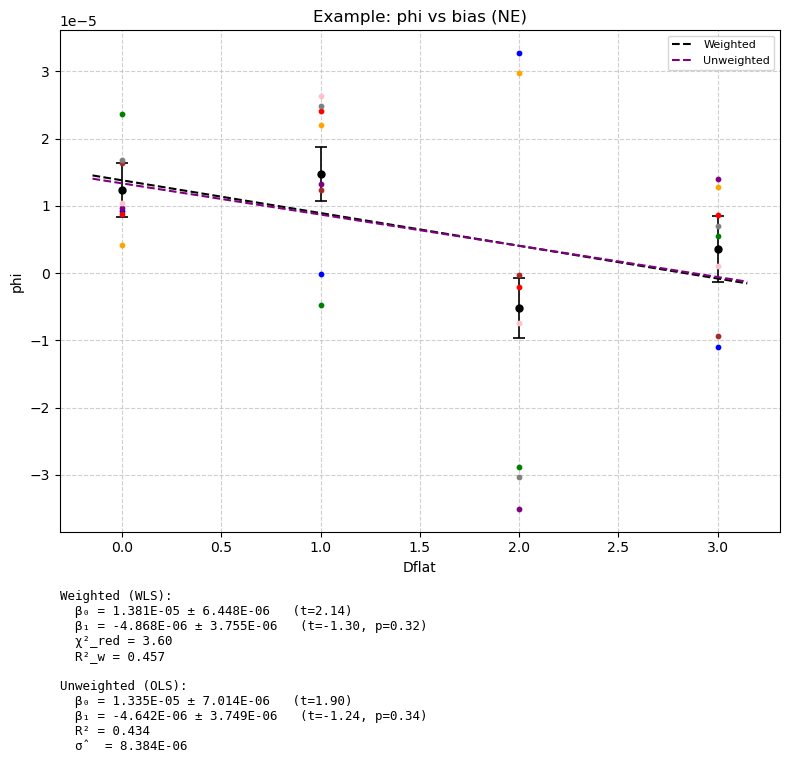

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erf

def _safe_t_pvalue(tstat: float, dof: int) -> float:
    """Two-sided p-value for a t-statistic; SciPy if available, else normal approx."""
    try:
        from scipy.stats import t as tdist  # type: ignore
        return 2.0 * tdist.sf(abs(tstat), df=dof)
    except Exception:
        z = abs(tstat)
        phi = 0.5 * (1.0 + erf(z / np.sqrt(2.0)))
        return max(0.0, min(1.0, 2.0 * (1.0 - phi)))

def _linear_fit_with_cov(x, y, sigma=None):
    """
    Fit y = β0 + β1 x.
    If sigma provided: WLS with weights 1/sigma^2, else OLS.
    Returns dict with β0, β1, their SEs, t-stats, dof, chi2_red (WLS), yfit,
    and R^2 (weighted if WLS), plus sigma_hat for OLS.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    X = np.column_stack((np.ones_like(x), x))
    dof = max(n - 2, 1)

    if sigma is not None:
        w = 1.0 / np.asarray(sigma, dtype=float)**2
        W = np.diag(w)
        XtWX = X.T @ W @ X
        XtWy = X.T @ W @ y
        beta = np.linalg.solve(XtWX, XtWy)  # [β0, β1]
        yfit = X @ beta
        # chi2 and covariance (scaled by reduced chi^2)
        chi2 = float(np.sum(w * (y - yfit)**2))
        chi2_red = chi2 / dof
        cov = np.linalg.inv(XtWX) * chi2_red
        # Weighted R^2
        ybar_w = np.sum(w * y) / np.sum(w)
        ss_res_w = np.sum(w * (y - yfit)**2)
        ss_tot_w = np.sum(w * (y - ybar_w)**2)
        r2 = float(1.0 - ss_res_w / ss_tot_w) if ss_tot_w > 0 else np.nan
        sigma_hat = None
    else:
        XtX = X.T @ X
        XtY = X.T @ y
        beta = np.linalg.solve(XtX, XtY)
        yfit = X @ beta
        resid = y - yfit
        s2 = float((resid @ resid) / dof)        # variance estimator
        cov = np.linalg.inv(XtX) * s2
        chi2_red = None
        # Classic R^2
        ybar = float(np.mean(y))
        ss_res = float(np.sum((y - yfit)**2))
        ss_tot = float(np.sum((y - ybar)**2))
        r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
        sigma_hat = float(np.sqrt(s2))

    se = np.sqrt(np.diag(cov))
    tstats = beta / se
    return {
        "beta0": float(beta[0]),
        "beta1": float(beta[1]),
        "se0": float(se[0]),
        "se1": float(se[1]),
        "t0": float(tstats[0]),
        "t1": float(tstats[1]),
        "cov": cov,
        "yfit": yfit,
        "dof": dof,
        "chi2_red": chi2_red,
        "r2": r2,
        "sigma_hat": sigma_hat,  # only non-None for OLS
    }

def _plot_sipm_errorbar(
    channel: str,
    sipm_df: pd.DataFrame,
    quantity_of_interest: str,
    plot_against: str,
    title: str = "",
    *,
    linear_fit: bool = False,
):
    """
    Top subplot: error bars (avg ± unc) and SiPM scatters (0..7).
    Bottom subplot: neatly formatted fit results (WLS & OLS) with β0/β1, SEs, t-stats,
    p-value for β1, R^2, and σ̂ for OLS.
    """
    sipm_colors_list = [
        "blue","orange","green","red","purple","brown","pink","gray"
    ]

    base = f"{quantity_of_interest}_{channel}_"
    sipm_cols = [base + f"sipm{i}" for i in range(8)]
    sipm_avg_col = base + "sipmavg"
    unc_cols = [f"uncertainty_{c}" for c in sipm_cols]
    unc_avg_col = f"uncertainty_{sipm_avg_col}"

    needed_cols = [plot_against, sipm_avg_col, unc_avg_col] + sipm_cols + unc_cols
    missing = [c for c in needed_cols if c not in sipm_df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    # Stable 2-row layout
    fig, (ax, ax_text) = plt.subplots(
        nrows=2, ncols=1, figsize=(8, 8),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Top: data ---
    for _, row in sipm_df.iterrows():
        x = row[plot_against]
        y_avg = row[sipm_avg_col]
        yerr_avg = row[unc_avg_col]

        ax.errorbar(
            x, y_avg, yerr=yerr_avg, fmt="o",
            ecolor="black", capsize=4, capthick=1.2, elinewidth=1.2,
            markersize=5, color="black"
        )
        for i, c in enumerate(sipm_cols):
            ax.scatter(x, row[c], s=10, color=sipm_colors_list[i], zorder=2)

        # (Optional) You can keep the per-point annotation here; omitted for clarity.

    ax.set_xlabel(plot_against)
    ax.set_ylabel(quantity_of_interest)
    ax.grid(True, linestyle="--", alpha=0.6)
    if title:
        ax.set_title(title)

    stats_lines = []

    if linear_fit:
        xdata = sipm_df[plot_against].to_numpy(float)
        ydata = sipm_df[sipm_avg_col].to_numpy(float)
        sdata = sipm_df[unc_avg_col].to_numpy(float)

        # OLS
        mask_ols = np.isfinite(xdata) & np.isfinite(ydata)
        ols = _linear_fit_with_cov(xdata[mask_ols], ydata[mask_ols], sigma=None)
        p_ols = _safe_t_pvalue(ols["t1"], ols["dof"])

        # WLS
        mask_wls = mask_ols & np.isfinite(sdata) & (sdata > 0)
        wls = _linear_fit_with_cov(xdata[mask_wls], ydata[mask_wls], sigma=sdata[mask_wls])
        p_wls = _safe_t_pvalue(wls["t1"], wls["dof"])

        # Lines
        xmin, xmax = ax.get_xlim()
        xx = np.linspace(xmin, xmax, 200)
        ax.plot(xx, wls["beta0"] + wls["beta1"] * xx, "--", color="black",  label="Weighted")
        ax.plot(xx, ols["beta0"] + ols["beta1"] * xx, "--", color="purple", label="Unweighted")
        ax.legend(loc="best", fontsize=8)

        # --- Bottom: results text ---
        stats_lines.append("Weighted (WLS):")
        stats_lines.append(f"  β₀ = {wls['beta0']:.3E} ± {wls['se0']:.3E}   (t={wls['t0']:.2f})")
        stats_lines.append(f"  β₁ = {wls['beta1']:.3E} ± {wls['se1']:.3E}   (t={wls['t1']:.2f}, p={p_wls:.2g})")
        if wls["chi2_red"] is not None:
            stats_lines.append(f"  χ²_red = {wls['chi2_red']:.2f}")
        stats_lines.append(f"  R²_w = {wls['r2']:.3f}")
        stats_lines.append("")

        stats_lines.append("Unweighted (OLS):")
        stats_lines.append(f"  β₀ = {ols['beta0']:.3E} ± {ols['se0']:.3E}   (t={ols['t0']:.2f})")
        stats_lines.append(f"  β₁ = {ols['beta1']:.3E} ± {ols['se1']:.3E}   (t={ols['t1']:.2f}, p={p_ols:.2g})")
        stats_lines.append(f"  R² = {ols['r2']:.3f}")
        stats_lines.append(f"  σ̂  = {ols['sigma_hat']:.3E}")

    ax_text.axis("off")
    if stats_lines:
        ax_text.text(
            0.0, 1.0, "\n".join(stats_lines),
            ha="left", va="top", family="monospace", fontsize=9
        )

    fig.tight_layout()
    return fig, (ax, ax_text)



example = a.sequenceresult.sequencesipmdf
# Average columns
vals = example[[f"phi_NE_sipm{i}" for i in range(8)]].values
example["phi_NE_sipmavg"] = vals.mean(axis=1)
example["uncertainty_phi_NE_sipmavg"] = np.sqrt(np.sum(example[[f"uncertainty_phi_NE_sipm{i}" for i in range(8)]].values**2, axis=1)) / 8.0

# Plot
fig, ax = _plot_sipm_errorbar(
    channel="NE",
    sipm_df=example,
    quantity_of_interest="phi",
    plot_against="Dflat",
    title="Example: phi vs bias (NE)",
    linear_fit=True,
)
plt.show()

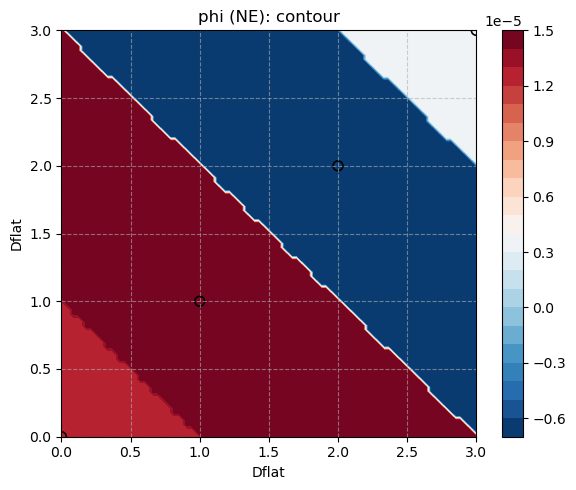

In [16]:
fig, ax = _plot_sipm_contour2d(
    channel="NE",
    sipm_df= a.sequenceresult.sequencesipmdf,
    quantity_of_interest="phi",
    plot_against_x= a.sequenceresult.non_parity_switches[0],
    plot_against_y= a.sequenceresult.non_parity_switches[0],
    title="phi (NE): contour",
    baseline = None,            # set to None for automatic
    levels=20,
    cmap="RdBu_r",
)

In [ ]:
a.sequenceresult.non_parity_switches

In [20]:
visualize_2d(a,
    ['phi','C'],                      # str | list[str]  -> z quantities to plot
    [a.sequenceresult.non_parity_switches[0], a.sequenceresult.non_parity_switches[0]],           # [plot_against_x, plot_against_y]
    baseline = None,
    levels = 20,
    cmap = "RdBu_r",
    out_folder_name = "result_2d")

C:\Users\ACME\AppData\Local\Temp\ipykernel_21156\196313057.py:94: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
